In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
df_year = pd.read_csv("./data_important/faculties_gender_race_year_v2.csv")
df = pd.read_csv("./data_important/faculties_gender_race.csv")

df_overall = df.drop(columns=['Department']).drop_duplicates()
df.shape, df_overall.shape, df_year.shape

((749, 13), (692, 12), (40368, 13))

In [4]:
df_overall['RankName'].value_counts()

Professor    385
Other        123
Associate    104
Assistant     80
Name: RankName, dtype: int64

In [5]:
df_year_check = df_year[['Id', 'RankName', 'Name']].drop_duplicates().RankName.value_counts()
df_year_check

Professor    385
Other        123
Associate    104
Assistant     80
Name: RankName, dtype: int64

In [6]:
df_year_overall = df_year.drop(columns=['Department']).drop_duplicates()
df_year_overall = df_year_overall.sort_values(by=['Year']).dropna(subset=['Year'])
df_year_overall = df_year_overall[(df_year_overall.Year != 'Suppl')
                                 & (df_year_overall.Year != 'First Serie.1 ')
                                 & (df_year_overall.Year != 'No Issue')
                                 & (df_year_overall.Year != '1')
                                 & (df_year_overall.Year != '2')]
df_year_overall.Year

36798    1900
37401    1917
553      1958
35945    1959
35946    1960
         ... 
28082    2021
27862    2021
28139    2021
28057    2021
27944    2021
Name: Year, Length: 13000, dtype: object

In [7]:
df_old = df_year_overall[df_year_overall.RankName=='Professor'].drop(columns=['Id', 'Name', 'LastName', 'FirstName'])
df_new = df_year_overall[df_year_overall.RankName!='Professor'].drop(columns=['Id', 'Name', 'LastName', 'FirstName'])
df_old.shape, df_new.shape

((8079, 8), (4921, 8))

## Gender

In [8]:
df_old.head(2)

,Gender,RankName,Race,Year,ArticleCount,ConfProcCount,GrantCount,PatentCount
36798,Male,Professor,PCTWHITE,1900,1.0,0.0,0.0,0.0
553,Female,Professor,PCTWHITE,1958,1.0,0.0,0.0,0.0


In [9]:
df_old_gender = df_old.groupby(by=['Year', 'Gender']).sum().reset_index()
v = df_old_gender.Year.value_counts()
missing = df_old_gender[~df_old_gender.Year.isin(v.index[v.gt(1)])]
suppl_df = pd.DataFrame(columns=['Year', 'Gender', 'ArticleCount', 'ConfProcCount', 'GrantCount', 'PatentCount'])
row, col = missing.shape

for i in range(row):
    if missing.iloc[[i]].Gender.values[0] == 'Male':
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], 'Female', 0, 0, 0, 0]
    else:
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], 'Male', 0, 0, 0, 0]

df_old_gender = pd.concat([df_old_gender, suppl_df], ignore_index=True).sort_values(by=['Year'])
df_old_gender = df_old_gender[df_old_gender.Year > '1971']
df_old_gender.head(2)

,Year,Gender,ArticleCount,ConfProcCount,GrantCount,PatentCount
3,1972,Male,1,0,0,0
98,1972,Female,0,0,0,0


In [10]:
df_new.head(2)

,Gender,RankName,Race,Year,ArticleCount,ConfProcCount,GrantCount,PatentCount
37401,Female,Other,PCTWHITE,1917,1.0,0.0,0.0,0.0
35945,Female,Other,PCTWHITE,1959,1.0,0.0,0.0,0.0


In [11]:
df_new_gender = df_new.groupby(by=['Year', 'Gender']).sum().reset_index()
v = df_new_gender.Year.value_counts()
missing = df_new_gender[~df_new_gender.Year.isin(v.index[v.gt(1)])]
suppl_df = pd.DataFrame(columns=['Year', 'Gender', 'ArticleCount', 'ConfProcCount', 'GrantCount', 'PatentCount'])
row, col = missing.shape

for i in range(row):
    if missing.iloc[[i]].Gender.values[0] == 'Male':
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], 'Female', 0, 0, 0, 0]
    else:
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], 'Male', 0, 0, 0, 0]

df_new_gender = pd.concat([df_new_gender, suppl_df], ignore_index=True).sort_values(by=['Year'])
df_new_gender = df_new_gender[df_new_gender.Year > '1971']
df_new_gender.head(2)

,Year,Gender,ArticleCount,ConfProcCount,GrantCount,PatentCount
5,1972,Female,0,0,0,1
6,1972,Male,0,0,0,1


In [12]:
year_old = df_old_gender.Year.drop_duplicates()
year_new = df_new_gender.Year.drop_duplicates()

In [13]:
gender = df_overall.groupby(by=['RankName', 'Gender']).count()[['Id']].reset_index()

f_old = gender[(gender.RankName=='Professor') & (gender.Gender=='Female')].Id.values[0]
m_old = gender[(gender.RankName=='Professor') & (gender.Gender=='Male')].Id.values[0]
gender = gender[gender.RankName!='Professor']
f_new = gender[gender.Gender=='Female'].Id.sum()
m_new = gender[gender.Gender=='Male'].Id.sum()

fidx_old = f_old/(f_old+m_old)
fidx_new = f_new/(f_new+m_new)
midx_old = m_old/(f_old+m_old)
midx_new = m_new/(f_new+m_new)

# Race

In [14]:
df_old_race = df_old.groupby(by=['Year', 'Race']).sum().reset_index()
races = ['PCTWHITE', 'PCTAPI', 'PCTBLACK', 'PCTHISPANIC']
v = df_old_race.Year.value_counts()
missing = df_old_race[df_old_race.Year.isin(v.index[v.lt(4)])]
suppl_df = pd.DataFrame(columns=['Year', 'Race', 'ArticleCount', 'ConfProcCount', 'GrantCount', 'PatentCount'])
row, col = missing.shape

for i in range(row):
    year = missing.iloc[[i]].Year.values[0]
    exist = list(missing[missing.Year == year].Race.values)
    diff = list(set(races) - set(exist))
    while len(diff) > 0:
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], diff.pop(), 0, 0, 0, 0]
suppl_df = suppl_df.drop_duplicates()

df_old_race = pd.concat([df_old_race, suppl_df], ignore_index=True).sort_values(by=['Year'])
df_old_race = df_old_race[df_old_race.Year > '1971']
df_old_race.head(2)

,Year,Race,ArticleCount,ConfProcCount,GrantCount,PatentCount
3,1972,PCTWHITE,1,0,0,0
158,1972,PCTHISPANIC,0,0,0,0


In [15]:
df_new_race = df_new.groupby(by=['Year', 'Race']).sum().reset_index()


v = df_new_race.Year.value_counts()
missing = df_new_race[df_new_race.Year.isin(v.index[v.lt(4)])]
suppl_df = pd.DataFrame(columns=['Year', 'Race', 'ArticleCount', 'ConfProcCount', 'GrantCount', 'PatentCount'])
row, col = missing.shape

for i in range(row):
    year = missing.iloc[[i]].Year.values[0]
    exist = list(missing[missing.Year == year].Race.values)
    diff = list(set(races) - set(exist))
    while len(diff) > 0:
        suppl_df.loc[len(suppl_df.index)] = [missing.iloc[[i]].Year.values[0], diff.pop(), 0, 0, 0, 0]
suppl_df = suppl_df.drop_duplicates()

df_new_race = pd.concat([df_new_race, suppl_df], ignore_index=True).sort_values(by=['Year'])
df_new_race = df_new_race[df_new_race.Year > '1971']
df_new_race.head(2)

,Year,Race,ArticleCount,ConfProcCount,GrantCount,PatentCount
119,1972,PCTAPI,0,0,0,0
120,1972,PCTHISPANIC,0,0,0,0


In [16]:
race = df_overall.groupby(by=['RankName', 'Race']).count()[['Id']].reset_index()

wh_old = race[(race.RankName=='Professor') & (race.Race=='PCTWHITE')].Id.values[0]
ap_old = race[(race.RankName=='Professor') & (race.Race=='PCTAPI')].Id.values[0]
bl_old = race[(race.RankName=='Professor') & (race.Race=='PCTBLACK')].Id.values[0]
hp_old = race[(race.RankName=='Professor') & (race.Race=='PCTHISPANIC')].Id.values[0]
race = race[race.RankName!='Professor']
wh_new = race[race.Race=='PCTWHITE'].Id.sum()
ap_new = race[race.Race=='PCTAPI'].Id.sum()
bl_new = race[race.Race=='PCTBLACK'].Id.sum() + 0.000000001
hp_new = race[race.Race=='PCTHISPANIC'].Id.sum()

# whidx_old = wh_old/(wh_old+ap_old+bl_old+hp_old)
# whidx_new = wh_new/(wh_new+ap_new+bl_new+hp_new)
# apidx_old = ap_old/(wh_old+ap_old+bl_old+hp_old)
# apidx_new = ap_new/(wh_new+ap_new+bl_new+hp_new)
# blidx_old = bl_old/(wh_old+ap_old+bl_old+hp_old)
# blidx_new = bl_new/(wh_new+ap_new+bl_new+hp_new) + 0.000000001
# hpidx_old = hp_old/(wh_old+ap_old+bl_old+hp_old)
# hpidx_new = hp_new/(wh_new+ap_new+bl_new+hp_new)

# whidx_old, whidx_new, apidx_old, apidx_new, blidx_old, blidx_new, hpidx_old, hpidx_new

# Patent

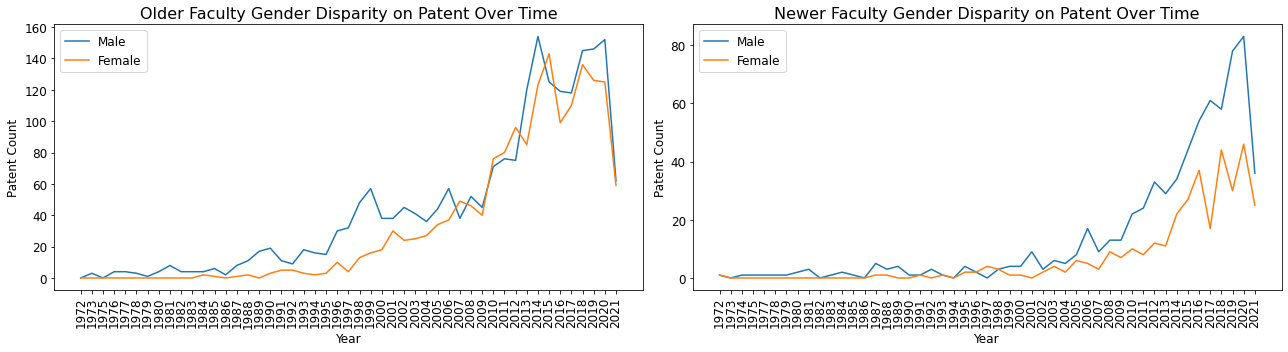

In [17]:
patent_male_old = df_old_gender[df_old_gender.Gender == 'Male'].PatentCount
patent_female_old = df_old_gender[df_old_gender.Gender == 'Female'].PatentCount
patent_male_new = df_new_gender[df_new_gender.Gender == 'Male'].PatentCount
patent_female_new = df_new_gender[df_new_gender.Gender == 'Female'].PatentCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(year_old, patent_male_old)
ax1.plot(year_old, patent_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Patent Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Patent Over Time")

ax2.plot(year_new, patent_male_new)
ax2.plot(year_new, patent_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Patent Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Patent Over Time")

plt.tight_layout()

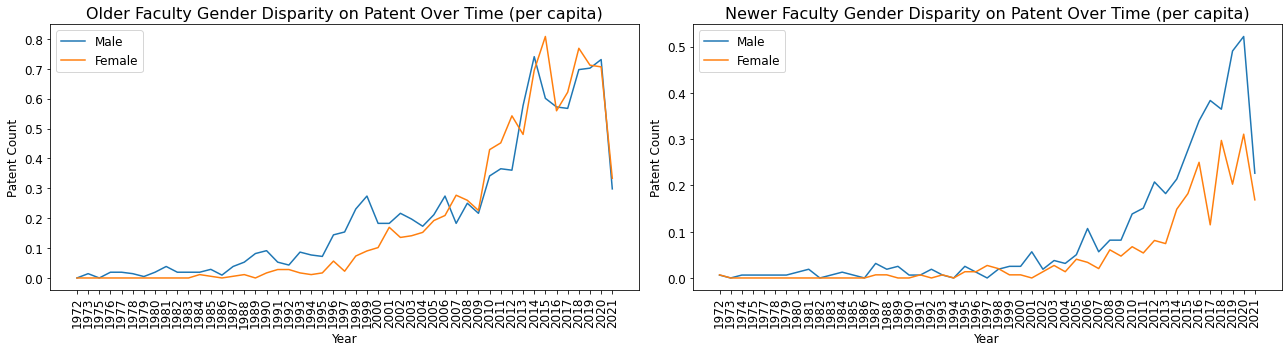

In [18]:
patent_male_old = [num/m_old for num in patent_male_old]
patent_female_old = [num/f_old for num in patent_female_old]
patent_male_new = [num/m_new for num in patent_male_new]
patent_female_new = [num/f_new for num in patent_female_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, patent_male_old)
ax1.plot(year_old, patent_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Patent Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Patent Over Time (per capita)")

ax2.plot(year_new, patent_male_new)
ax2.plot(year_new, patent_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Patent Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Patent Over Time (per capita)")

plt.tight_layout()

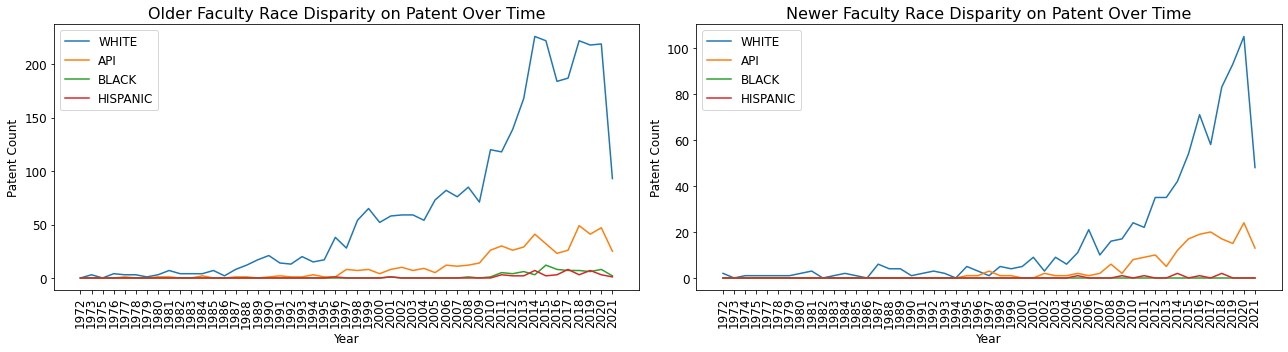

In [19]:
patent_wh_old = df_old_race[df_old_race.Race == 'PCTWHITE'].PatentCount
patent_ap_old = df_old_race[df_old_race.Race == 'PCTAPI'].PatentCount
patent_bl_old = df_old_race[df_old_race.Race == 'PCTBLACK'].PatentCount
patent_hp_old = df_old_race[df_old_race.Race == 'PCTHISPANIC'].PatentCount

patent_wh_new = df_new_race[df_new_race.Race == 'PCTWHITE'].PatentCount
patent_ap_new = df_new_race[df_new_race.Race == 'PCTAPI'].PatentCount
patent_bl_new = df_new_race[df_new_race.Race == 'PCTBLACK'].PatentCount
patent_hp_new = df_new_race[df_new_race.Race == 'PCTHISPANIC'].PatentCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, patent_wh_old)
ax1.plot(year_old, patent_ap_old)
ax1.plot(year_old, patent_bl_old)
ax1.plot(year_old, patent_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Patent Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Patent Over Time")

ax2.plot(year_new, patent_wh_new)
ax2.plot(year_new, patent_ap_new)
ax2.plot(year_new, patent_bl_new)
ax2.plot(year_new, patent_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Patent Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Patent Over Time")

plt.tight_layout()

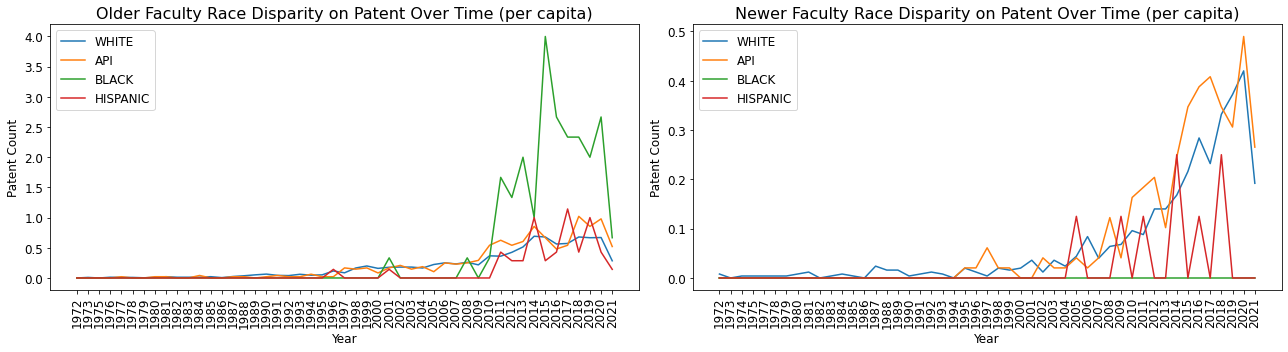

In [20]:
patent_wh_old = [num/wh_old for num in patent_wh_old]
patent_ap_old = [num/ap_old for num in patent_ap_old]
patent_bl_old = [num/bl_old for num in patent_bl_old]
patent_hp_old = [num/hp_old for num in patent_hp_old]

patent_wh_new = [num/wh_new for num in patent_wh_new]
patent_ap_new = [num/ap_new for num in patent_ap_new]
patent_bl_new = [num/bl_new for num in patent_bl_new]
patent_hp_new = [num/hp_new for num in patent_hp_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, patent_wh_old)
ax1.plot(year_old, patent_ap_old)
ax1.plot(year_old, patent_bl_old)
ax1.plot(year_old, patent_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Patent Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Patent Over Time (per capita)")

ax2.plot(year_new, patent_wh_new)
ax2.plot(year_new, patent_ap_new)
ax2.plot(year_new, patent_bl_new)
ax2.plot(year_new, patent_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Patent Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Patent Over Time (per capita)")

plt.tight_layout()

The change in HISPANIC is quite huge, the small portion of this race in the dataset is one big factor.

# Article

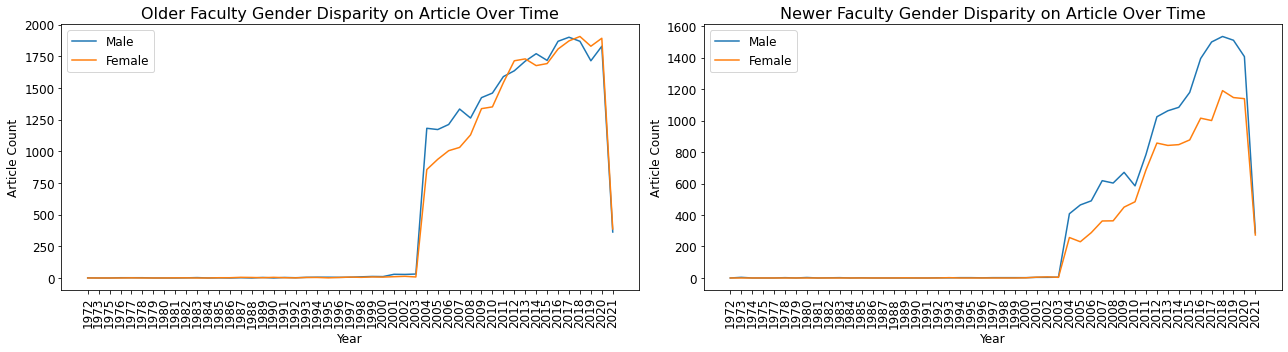

In [31]:
article_male_old = df_old_gender[df_old_gender.Gender == 'Male'].ArticleCount
article_female_old = df_old_gender[df_old_gender.Gender == 'Female'].ArticleCount
article_male_new = df_new_gender[df_new_gender.Gender == 'Male'].ArticleCount
article_female_new = df_new_gender[df_new_gender.Gender == 'Female'].ArticleCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, article_male_old)
ax1.plot(year_old, article_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Article Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Article Over Time")

ax2.plot(year_new, article_male_new)
ax2.plot(year_new, article_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Article Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Article Over Time")

plt.tight_layout()

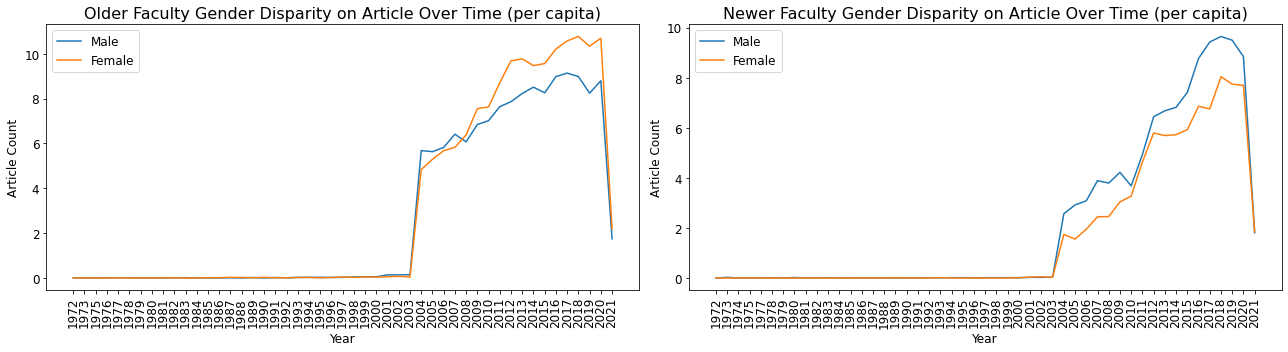

In [32]:
article_male_old = [num/m_old for num in article_male_old]
article_female_old = [num/f_old for num in article_female_old]
article_male_new = [num/m_new for num in article_male_new]
article_female_new = [num/f_new for num in article_female_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, article_male_old)
ax1.plot(year_old, article_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Article Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Article Over Time (per capita)")

ax2.plot(year_new, article_male_new)
ax2.plot(year_new, article_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Article Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Article Over Time (per capita)")

plt.tight_layout()


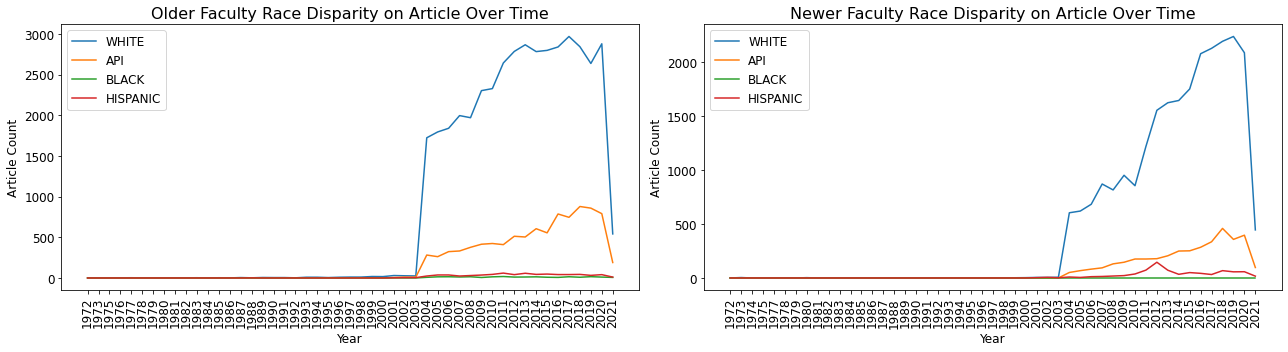

In [22]:
article_wh_old = df_old_race[df_old_race.Race == 'PCTWHITE'].ArticleCount
article_ap_old = df_old_race[df_old_race.Race == 'PCTAPI'].ArticleCount
article_bl_old = df_old_race[df_old_race.Race == 'PCTBLACK'].ArticleCount
article_hp_old = df_old_race[df_old_race.Race == 'PCTHISPANIC'].ArticleCount

article_wh_new = df_new_race[df_new_race.Race == 'PCTWHITE'].ArticleCount
article_ap_new = df_new_race[df_new_race.Race == 'PCTAPI'].ArticleCount
article_bl_new = df_new_race[df_new_race.Race == 'PCTBLACK'].ArticleCount
article_hp_new = df_new_race[df_new_race.Race == 'PCTHISPANIC'].ArticleCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, article_wh_old)
ax1.plot(year_old, article_ap_old)
ax1.plot(year_old, article_bl_old)
ax1.plot(year_old, article_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Article Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Article Over Time")

ax2.plot(year_new, article_wh_new)
ax2.plot(year_new, article_ap_new)
ax2.plot(year_new, article_bl_new)
ax2.plot(year_new, article_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Article Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Article Over Time")

plt.tight_layout()

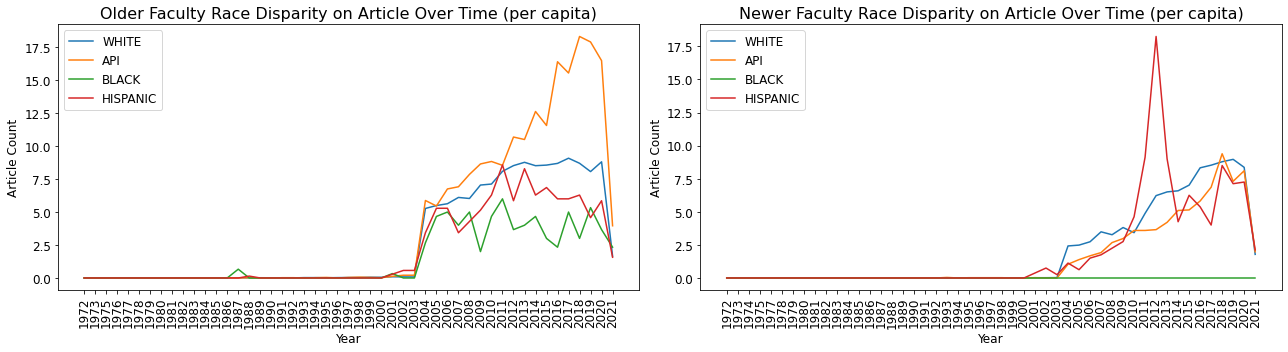

In [23]:
article_wh_old = [num/wh_old for num in article_wh_old]
article_ap_old = [num/ap_old for num in article_ap_old]
article_bl_old = [num/bl_old for num in article_bl_old]
article_hp_old = [num/hp_old for num in article_hp_old]

article_wh_new = [num/wh_new for num in article_wh_new]
article_ap_new = [num/ap_new for num in article_ap_new]
article_bl_new = [num/bl_new for num in article_bl_new]
article_hp_new = [num/hp_new for num in article_hp_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, article_wh_old)
ax1.plot(year_old, article_ap_old)
ax1.plot(year_old, article_bl_old)
ax1.plot(year_old, article_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Article Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Article Over Time (per capita)")

ax2.plot(year_new, article_wh_new)
ax2.plot(year_new, article_ap_new)
ax2.plot(year_new, article_bl_new)
ax2.plot(year_new, article_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Article Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Article Over Time (per capita)")

plt.tight_layout()


# Conference

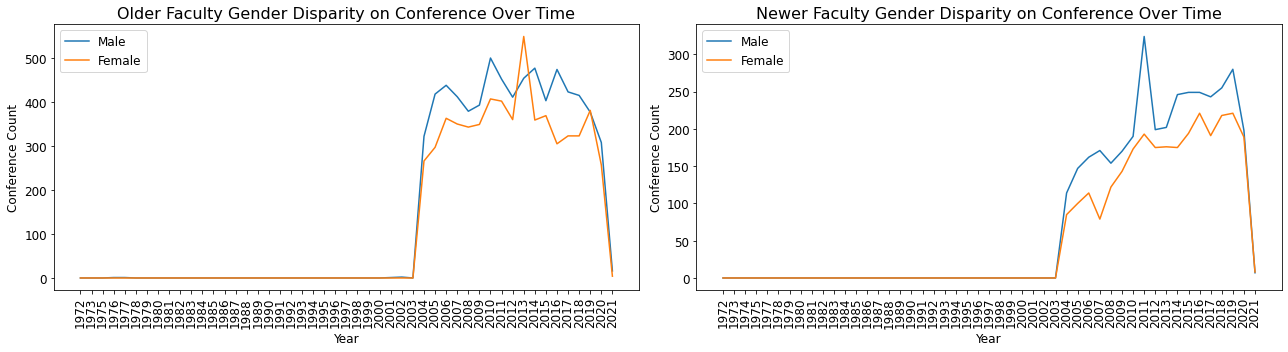

In [33]:
conf_male_old = df_old_gender[df_old_gender.Gender == 'Male']. ConfProcCount
conf_female_old = df_old_gender[df_old_gender.Gender == 'Female']. ConfProcCount
conf_male_new = df_new_gender[df_new_gender.Gender == 'Male']. ConfProcCount
conf_female_new = df_new_gender[df_new_gender.Gender == 'Female']. ConfProcCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, conf_male_old)
ax1.plot(year_old, conf_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Conference Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Conference Over Time")

ax2.plot(year_new, conf_male_new)
ax2.plot(year_new, conf_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Conference Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Conference Over Time")

plt.tight_layout()


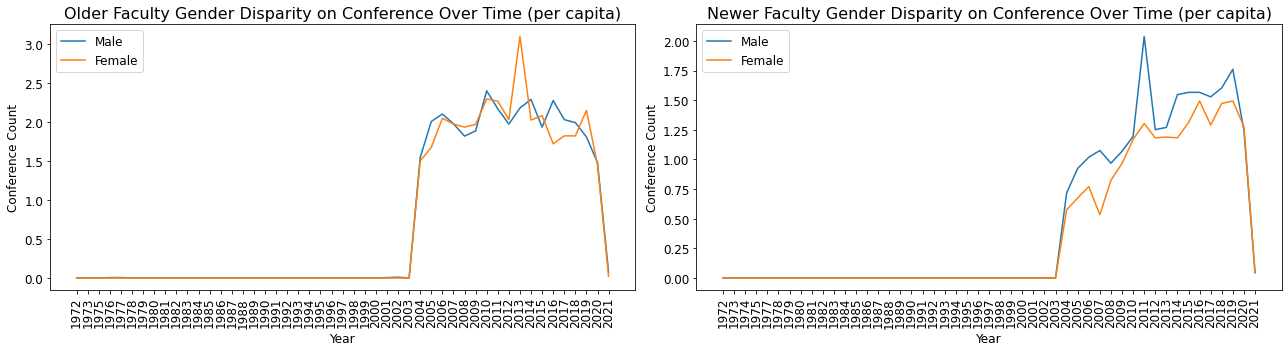

In [34]:
conf_male_old = [num/m_old for num in conf_male_old]
conf_female_old = [num/f_old for num in conf_female_old]
conf_male_new = [num/m_new for num in conf_male_new]
conf_female_new = [num/f_new for num in conf_female_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, conf_male_old)
ax1.plot(year_old, conf_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Conference Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Conference Over Time (per capita)")

ax2.plot(year_new, conf_male_new)
ax2.plot(year_new, conf_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Conference Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Conference Over Time (per capita)")

plt.tight_layout()


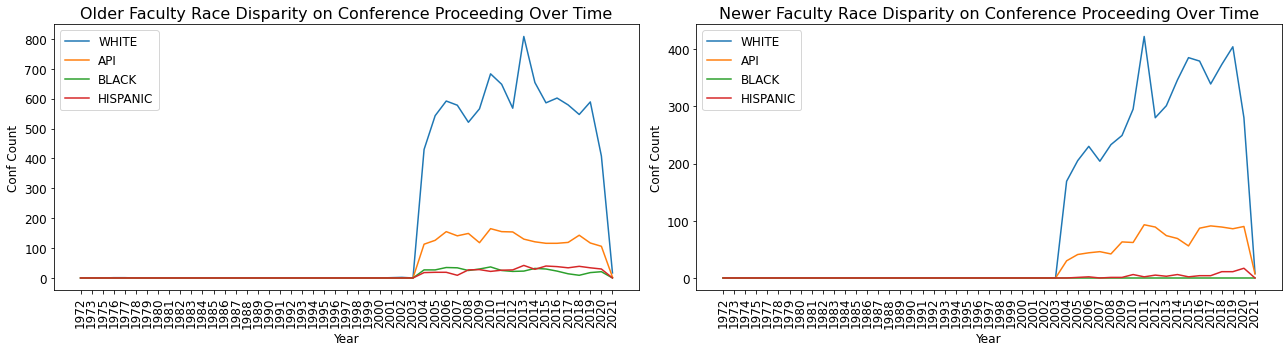

In [37]:
conf_wh_old = df_old_race[df_old_race.Race == 'PCTWHITE'].ConfProcCount
conf_ap_old = df_old_race[df_old_race.Race == 'PCTAPI'].ConfProcCount
conf_bl_old = df_old_race[df_old_race.Race == 'PCTBLACK'].ConfProcCount
conf_hp_old = df_old_race[df_old_race.Race == 'PCTHISPANIC'].ConfProcCount

conf_wh_new = df_new_race[df_new_race.Race == 'PCTWHITE'].ConfProcCount
conf_ap_new = df_new_race[df_new_race.Race == 'PCTAPI'].ConfProcCount
conf_bl_new = df_new_race[df_new_race.Race == 'PCTBLACK'].ConfProcCount
conf_hp_new = df_new_race[df_new_race.Race == 'PCTHISPANIC'].ConfProcCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, conf_wh_old)
ax1.plot(year_old, conf_ap_old)
ax1.plot(year_old, conf_bl_old)
ax1.plot(year_old, conf_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Conf Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Conference Proceeding Over Time")

ax2.plot(year_new, conf_wh_new)
ax2.plot(year_new, conf_ap_new)
ax2.plot(year_new, conf_bl_new)
ax2.plot(year_new, conf_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Conf Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Conference Proceeding Over Time")

plt.tight_layout()

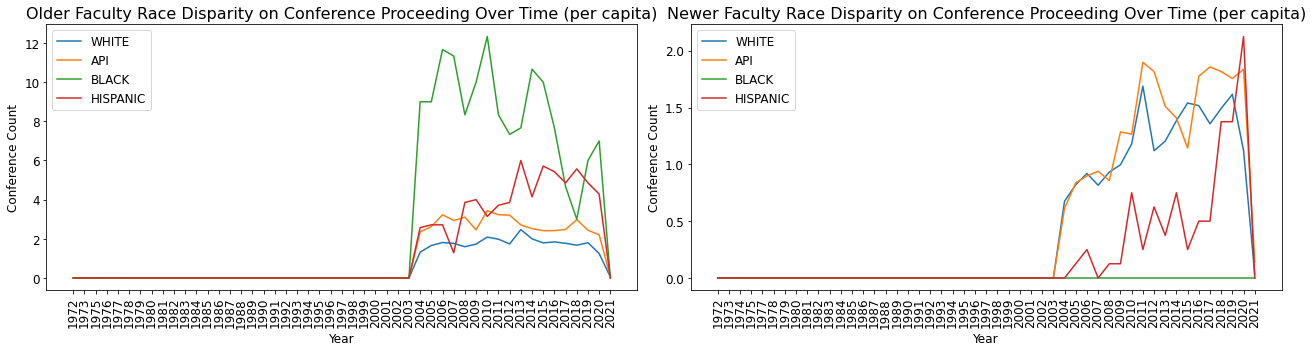

In [26]:
conf_wh_old = [num/wh_old for num in conf_wh_old]
conf_ap_old = [num/ap_old for num in conf_ap_old]
conf_bl_old = [num/bl_old for num in conf_bl_old]
conf_hp_old = [num/hp_old for num in conf_hp_old]

conf_wh_new = [num/wh_new for num in conf_wh_new]
conf_ap_new = [num/ap_new for num in conf_ap_new]
conf_bl_new = [num/bl_new for num in conf_bl_new]
conf_hp_new = [num/hp_new for num in conf_hp_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, conf_wh_old)
ax1.plot(year_old, conf_ap_old)
ax1.plot(year_old, conf_bl_old)
ax1.plot(year_old, conf_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Conference Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Conference Proceeding Over Time (per capita)")

ax2.plot(year_new, conf_wh_new)
ax2.plot(year_new, conf_ap_new)
ax2.plot(year_new, conf_bl_new)
ax2.plot(year_new, conf_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Conference Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Conference Proceeding Over Time (per capita)")

plt.tight_layout()

# Grant

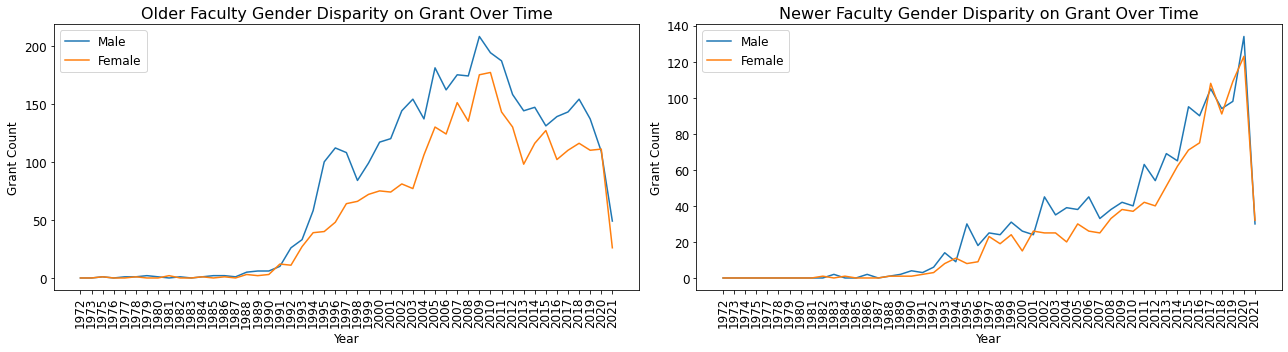

In [36]:
grant_male_old = df_old_gender[df_old_gender.Gender == 'Male'].GrantCount
grant_female_old = df_old_gender[df_old_gender.Gender == 'Female'].GrantCount
grant_male_new = df_new_gender[df_new_gender.Gender == 'Male'].GrantCount
grant_female_new = df_new_gender[df_new_gender.Gender == 'Female'].GrantCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, grant_male_old)
ax1.plot(year_old, grant_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Grant Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Grant Over Time")

ax2.plot(year_new, grant_male_new)
ax2.plot(year_new, grant_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Grant Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Grant Over Time")

plt.tight_layout()


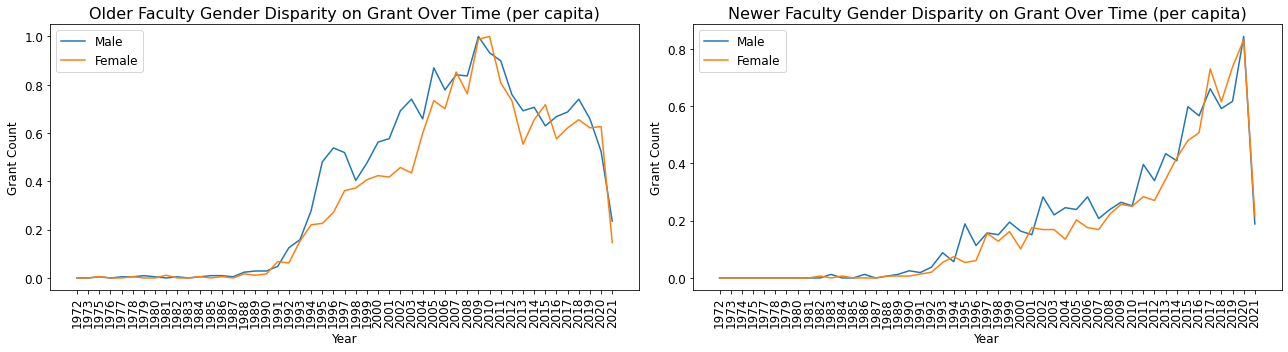

In [27]:
grant_male_old = [num/m_old for num in grant_male_old]
grant_female_old = [num/f_old for num in grant_female_old]
grant_male_new = [num/m_new for num in grant_male_new]
grant_female_new = [num/f_new for num in grant_female_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, grant_male_old)
ax1.plot(year_old, grant_female_old)
ax1.legend(['Male', 'Female'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Grant Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Gender Disparity on Grant Over Time (per capita)")

ax2.plot(year_new, grant_male_new)
ax2.plot(year_new, grant_female_new)
ax2.legend(['Male', 'Female'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Grant Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Gender Disparity on Grant Over Time (per capita)")

plt.tight_layout()


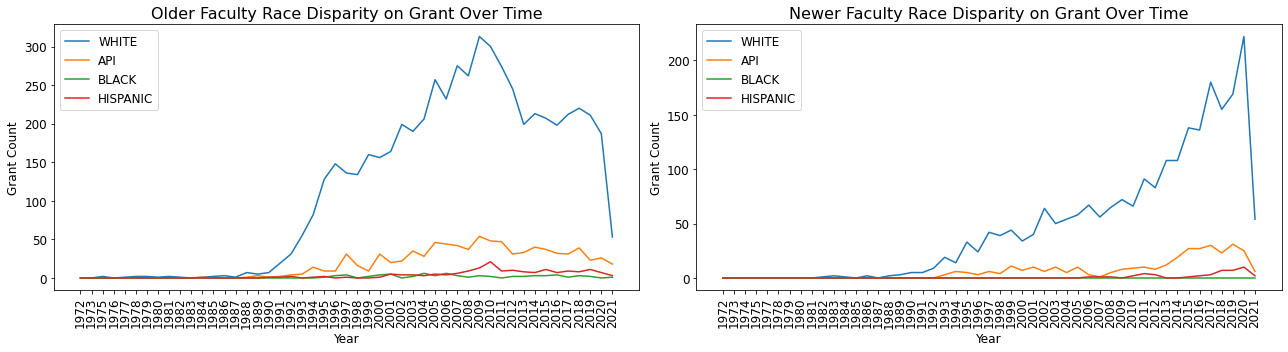

In [28]:
grant_wh_old = df_old_race[df_old_race.Race == 'PCTWHITE'].GrantCount
grant_ap_old = df_old_race[df_old_race.Race == 'PCTAPI'].GrantCount
grant_bl_old = df_old_race[df_old_race.Race == 'PCTBLACK'].GrantCount
grant_hp_old = df_old_race[df_old_race.Race == 'PCTHISPANIC'].GrantCount

grant_wh_new = df_new_race[df_new_race.Race == 'PCTWHITE'].GrantCount
grant_ap_new = df_new_race[df_new_race.Race == 'PCTAPI'].GrantCount
grant_bl_new = df_new_race[df_new_race.Race == 'PCTBLACK'].GrantCount
grant_hp_new = df_new_race[df_new_race.Race == 'PCTHISPANIC'].GrantCount

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, grant_wh_old)
ax1.plot(year_old, grant_ap_old)
ax1.plot(year_old, grant_bl_old)
ax1.plot(year_old, grant_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Grant Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Grant Over Time")

ax2.plot(year_new, grant_wh_new)
ax2.plot(year_new, grant_ap_new)
ax2.plot(year_new, grant_bl_new)
ax2.plot(year_new, grant_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Grant Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Grant Over Time")

plt.tight_layout()

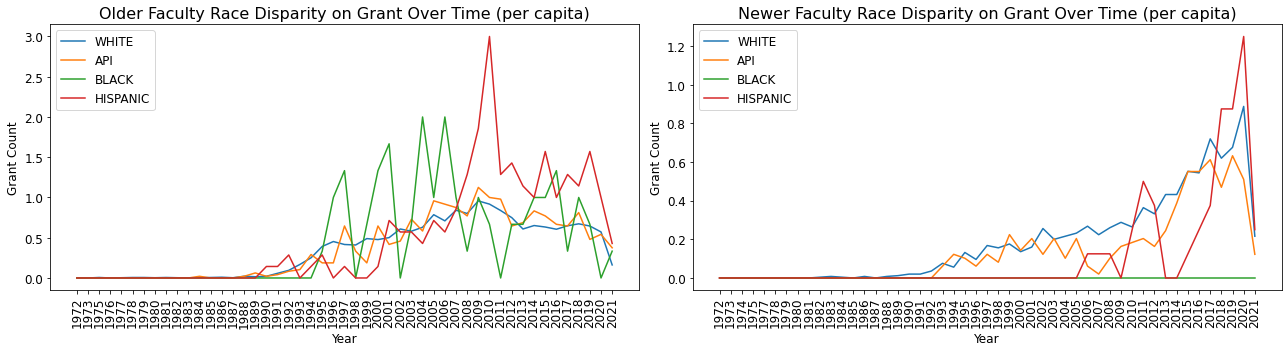

In [29]:
grant_wh_old = [num/wh_old for num in grant_wh_old]
grant_ap_old = [num/ap_old for num in grant_ap_old]
grant_bl_old = [num/bl_old for num in grant_bl_old]
grant_hp_old = [num/hp_old for num in grant_hp_old]

grant_wh_new = [num/wh_new for num in grant_wh_new]
grant_ap_new = [num/ap_new for num in grant_ap_new]
grant_bl_new = [num/bl_new for num in grant_bl_new]
grant_hp_new = [num/hp_new for num in grant_hp_new]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(year_old, grant_wh_old)
ax1.plot(year_old, grant_ap_old)
ax1.plot(year_old, grant_bl_old)
ax1.plot(year_old, grant_hp_old)
ax1.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax1.set_xlabel("Year")
ax1.set_ylabel("Grant Count")
ax1.tick_params('x', labelrotation=90)
ax1.title.set_text("Older Faculty Race Disparity on Grant Over Time (per capita)")

ax2.plot(year_new, grant_wh_new)
ax2.plot(year_new, grant_ap_new)
ax2.plot(year_new, grant_bl_new)
ax2.plot(year_new, grant_hp_new)
ax2.legend(['WHITE', 'API', 'BLACK', 'HISPANIC'], loc='upper left')
ax2.set_xlabel("Year")
ax2.set_ylabel("Grant Count")
ax2.tick_params('x', labelrotation=90)
ax2.title.set_text("Newer Faculty Race Disparity on Grant Over Time (per capita)")

plt.tight_layout()